In [28]:
# Поключаем пакеты для ML
import math
import json
from typing import Tuple


import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import patches
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.python.keras import engine
from tensorflow.keras import layers
import seaborn as sns
from scipy import stats

In [2]:
with open('../regression_model/data/train.json') as json_file:
    simulation_data = json.load(json_file)
simulation_data = pd.DataFrame.from_dict(simulation_data)
simulation_data
COLUMNS = [
    'num_stations',
    'queue_capacity',
    'mean_arrival_time',
    'std_arrival_time',
    'bitrate',
    'mean_packet_size', 
    'std_mean_packet_size',
    ]

In [3]:
simulation_data

,sta_where_packets_arrive,simulation_type,num_generated_packets,mode,num_stations,queue_capacity,mean_arrival_time,std_arrival_time,bitrate,mean_packet_size,std_mean_packet_size,e2e_delay
0,-1,True,100000,UPLOAD,9,7,54.773,52.189,50.990,212.273,212.273,12.726942
1,-1,True,100000,UPLOAD,5,7,50.453,54.160,50.840,208.914,208.914,5.682518
2,-1,True,100000,UPLOAD,7,7,53.907,51.207,50.461,212.252,212.252,9.058044
3,-1,True,100000,UPLOAD,2,7,53.021,54.301,50.965,209.556,209.556,2.162160
4,-1,True,100000,UPLOAD,1,7,52.363,53.718,50.202,213.335,213.335,1.062851
...,...,...,...,...,...,...,...,...,...,...,...,...
11281,-1,True,100000,UPLOAD,4,7,52.657,54.095,50.995,209.592,209.592,4.570062
11282,-1,True,100000,UPLOAD,3,7,52.764,53.586,50.141,212.881,212.881,3.332717
11283,-1,True,100000,UPLOAD,4,7,50.827,51.626,50.196,213.104,213.104,4.413418
11284,-1,True,100000,UPLOAD,3,7,54.832,52.534,50.640,210.063,210.063,3.451873


In [4]:
train_data, test_data, y_train, y_test = train_test_split(
    simulation_data, simulation_data.loc[:, 'e2e_delay'], 
    test_size=0.33, 
    random_state=42)
x_train = train_data.loc[:, COLUMNS]
x_test = test_data.loc[:, COLUMNS]

### МЕТРИКИ
Для оценки полученных моделей нам будут необходимы метрики, а именно:


- Стандартное отклонение

In [5]:
def std(x: np.ndarray, y: np.ndarray) -> float:
    """
    Standard deviation between simulation model 
    values and estimates
    """
    return math.sqrt(np.sum((x-y)**2) / (len(x) - 1))

- Коэффициент корреляции

In [6]:
def corr(x: np.ndarray, y: np.ndarray) -> float:
    """
    Correlation coefficient between simulation model 
    values and estimate 
    """
    r = np.corrcoef(x, y)
    return r[0,1]

- среднеквадратичная ошибка;

```sklearn.metrics.mean_squared_error ```.

- и коэффициент детерминации.

```sklearn.metrics.r2_score```.

### Приступим непосредственно к обучению

-  ## Задача регресии МНК

In [7]:
"""Prepare regression model using Least Squares algorithm"""
def get_ls_regression_model(x_train, x_test, 
                            y_train, y_test) -> (np.ndarray, 
                                                 LinearRegression):
    ls = LinearRegression()
    # ls = Ridge(alpha=.5)
    ls.fit(x_train, y_train)
    ls_y = ls.predict(x_test)

    return ls_y, ls


In [8]:
ls_delay_estimate, ls = get_ls_regression_model(x_train, 
                                                x_test, 
                                                y_train, 
                                                y_test)

In [9]:
print(f'R = {corr(y_test, ls_delay_estimate):.3f}')
print(f'STD = {std(y_test, ls_delay_estimate):.3f}')
print(f'MSE = {mean_squared_error(y_test, ls_delay_estimate):.3f}')
print(f'R2 = {r2_score(y_test, ls_delay_estimate):.3f}')
print(f'MAPE = {mean_absolute_percentage_error(y_test, ls_delay_estimate):.3f}')

R = 0.995
STD = 0.448
MSE = 0.201
R2 = 0.989
MAPE = 0.113


In [10]:
# DataFrame для отриосвки графиков
draw_data = test_data
draw_data.loc[:, 'LsDelayEst'] = ls_delay_estimate

/Users/m0000a/PycharmProjects/lin_net_cross_traffic_sim/venv/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/m0000a/PycharmProjects/lin_net_cross_traffic_sim/venv/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [11]:
draw_data['num_stations'].unique()

array([ 8,  5, 10,  7,  3,  6,  9,  4,  1,  2])

-  ## Задача регресии на дереве решений

In [12]:
"""Prepare regression model using Decision Tree algorithm"""
def get_tree_regression_model(x_train, x_test, 
                              y_train, y_test, 
                              max_depth=36, 
                              splitter='best') -> (np.ndarray, DecisionTreeRegressor):
    tree_reg = DecisionTreeRegressor(max_depth=max_depth, splitter=splitter)
    tree_reg.fit(x_train, y_train)
    tree_y = tree_reg.predict(x_test)
    
    # print(f'R = {corr(y_test, tree_y):.3f}')
    # print(f'STD = {std(y_test, tree_y):.3f}')
    # print(f'MSE = {mean_squared_error(y_test, tree_y):.3f}')

    return tree_y, tree_reg

In [13]:
tree_delay_estimate, tree_reg = get_tree_regression_model(x_train, 
                                                          x_test, 
                                                          y_train, 
                                                          y_test)

In [16]:
print(f'R = {corr(y_test, tree_delay_estimate,):.3f}')
print(f'STD = {std(y_test, tree_delay_estimate,):.3f}')
print(f'MSE = {mean_squared_error(y_test, tree_delay_estimate,):.3f}')
print(f'R2 = {r2_score(y_test, tree_delay_estimate,):.3f}')
print(f'MAPE = {mean_absolute_percentage_error(y_test, tree_delay_estimate):.3f}')

R = 1.000
STD = 0.105
MSE = 0.011
R2 = 0.999
MAPE = 0.008


In [18]:
draw_data.loc[:, 'TreeDelayEst'] = tree_delay_estimate 

-  ## Задача регрессии с помощью градиентного бустинга на деревьях решений

In [19]:
"""Prepare regression model using Gradient Boosting algorithm"""
def get_gtb_regression_model(x_train, x_test, 
                             y_train, y_test, 
                             n_estimators=100, 
                             learning_rate=.1,
                             max_depth=10) -> (np.ndarray, GradientBoostingRegressor):
    gtb = GradientBoostingRegressor(n_estimators=n_estimators, 
                                    learning_rate=learning_rate, 
                                    max_depth=max_depth)
    gtb.fit(x_train, y_train)
    gtb_y = gtb.predict(x_test)

    return gtb_y, gtb

In [20]:
gtb_delay_estimate, gtb = get_tree_regression_model(x_train, 
                                                    x_test, 
                                                    y_train, 
                                                    y_test)

In [22]:
print(f'R = {corr(y_test, gtb_delay_estimate,):.3f}')
print(f'STD = {std(y_test, gtb_delay_estimate,):.3f}')
print(f'MSE = {mean_squared_error(y_test, gtb_delay_estimate,):.3f}')
print(f'R2 = {r2_score(y_test, gtb_delay_estimate,):.3f}')
print(f'MAPE = {mean_absolute_percentage_error(y_test, gtb_delay_estimate):.3f}')

R = 1.000
STD = 0.105
MSE = 0.011
R2 = 0.999
MAPE = 0.008


In [24]:
draw_data.loc[:, 'GTBDelayEst'] = gtb_delay_estimate

-  ## Задача регрессии с помощью искуственной нейронной сети на алгоритме Adam


In [25]:
def normalize(table, stat) -> pd.core.frame.DataFrame:
    """Prepare data for ANN"""
    return (table - stat.loc['mean',:].transpose()) / stat.loc['std',:].transpose()

In [26]:
train_normalize = normalize(x_train, simulation_data.loc[:,COLUMNS].describe())
train_normalize.to_numpy();
test_normalize = normalize(x_test, simulation_data.loc[:,COLUMNS].describe())
test_normalize.to_numpy();

In [51]:
train_normalize['queue_capacity'] = 1
test_normalize['queue_capacity'] = 1

In [55]:
def build_model(size, activation='sigmoid') -> np.ndarray:
    model = keras.Sequential([
        # Input Layer
#         layers.Dense(18, activation=activation, 
#                      use_bias=True, input_shape=[size]),
        layers.Flatten(input_shape=[size]),
        # Hidden Layer
        layers.Dense(14, activation=activation, use_bias=True),
        # Output layer
        layers.Dense(1)])

    optimizer = tf.keras.optimizers.Adam(0.01)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse'])
    print(model.summary())
    return model


def get_ann_regression_model(train_normalize, 
                             test_normalize, 
                             y_train_ann, y_test_ann, 
                             size,
                             epochs=1000,
                             activation='sigmoid') -> Tuple[np.ndarray, 
                                                            engine.sequential.Sequential]:
    
    ann = build_model(size=size)
   
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    EPOCHS = epochs
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    ann.fit(train_normalize, y_train_ann, epochs=EPOCHS, validation_split=0.3, verbose=0, 
            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

    ann_y = ann.predict(test_normalize).flatten();
    
    return ann_y, ann


In [56]:
%%time
ann_delay_estimate, ann = get_ann_regression_model(train_normalize, 
                                                   test_normalize,
                                                   y_train, y_test,
                                                   size=len(simulation_data.loc[:,COLUMNS].keys()))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 14)                112       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 15        
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________
None
CPU times: user 10.5 s, sys: 1.71 s, total: 12.2 s
Wall time: 8.08 s


In [57]:
print(f'R = {corr(y_test, ann_delay_estimate):.3f}')
print(f'STD = {std(y_test, ann_delay_estimate):.3f}')
print(f'MSE = {mean_squared_error(y_test, ann_delay_estimate):.3f}')
print(f'R2 = {r2_score(y_test, ann_delay_estimate):.3f}')
print(f'MAPE = {mean_absolute_percentage_error(y_test, ann_delay_estimate):.3f}')

R = 1.000
STD = 0.084
MSE = 0.007
R2 = 1.000
MAPE = 0.014


In [61]:
# Добавим в draw_data оценку ann_y 
draw_data['AnnDelayEst'] = ann_delay_estimate

/Users/m0000a/PycharmProjects/lin_net_cross_traffic_sim/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


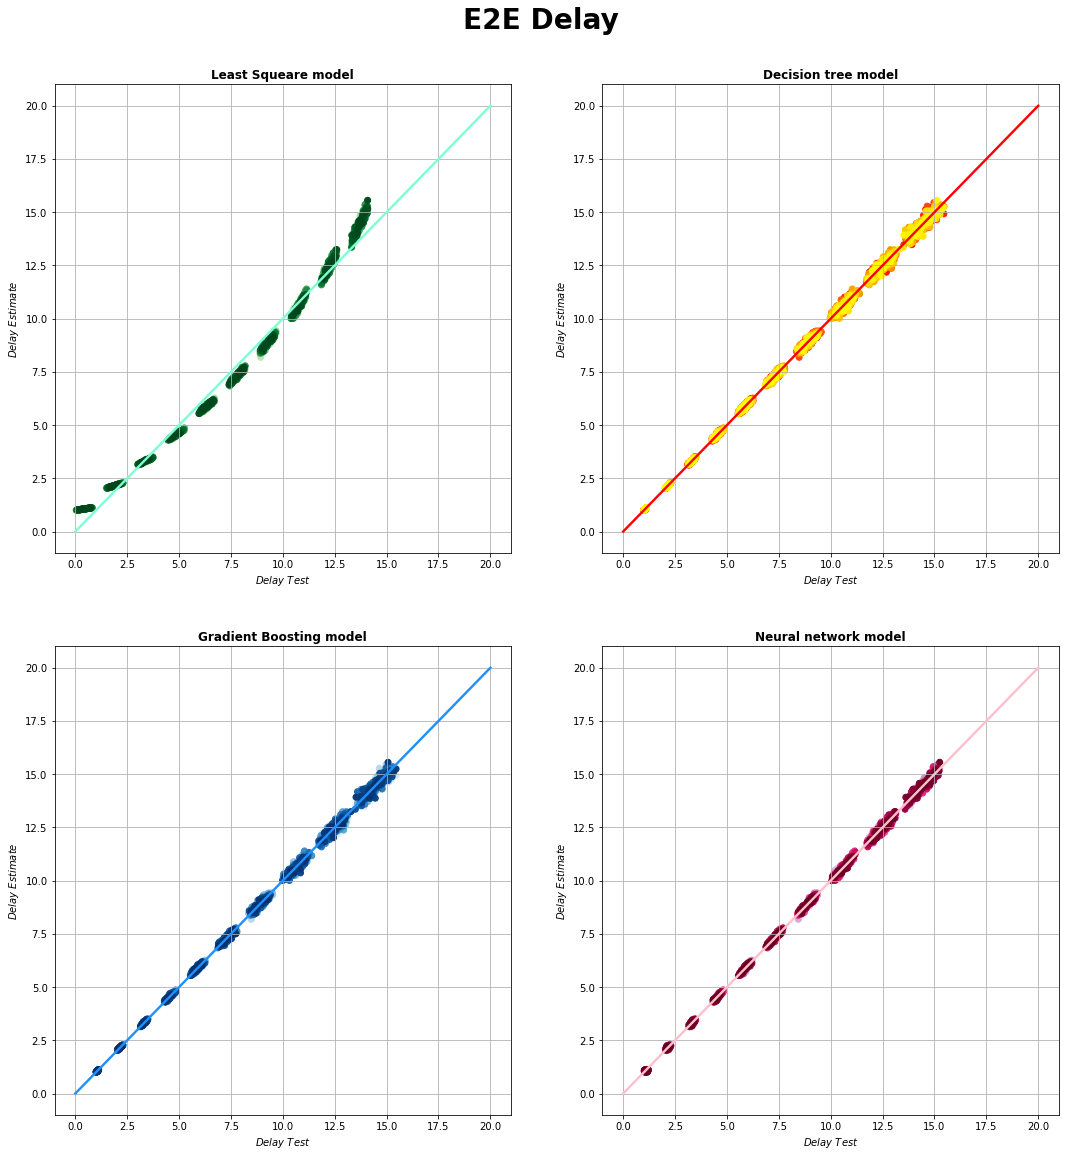

In [72]:
model = [ls_delay_estimate, 
         tree_delay_estimate,
         gtb_delay_estimate,
         ann_delay_estimate]

label = ['Least Squeare model',
         'Decision tree model',
         'Gradient Boosting model',
         'Neural network model']
column = ['LsDelayEst',
          'TreeDelayEst',
          'GTBDelayEst',
          'AnnDelayEst']
scatter_color = ['Greens',
                 'autumn',
                 'Blues',
                 'PuRd']
diag_line_color = ['aquamarine', 
                   'red',
                   'dodgerblue',
                   'pink']

fig = plt.figure(figsize=(18, 18))
plt.subplots_adjust(top=0.92)
fig.suptitle('E2E Delay', fontsize=28, fontweight='bold')
x = np.linspace(0,20,10)
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_title(label[i], fontdict={'fontweight': 'bold'})
    cm = plt.get_cmap(scatter_color[i])
    col = [cm(float(i)/(len(ann_delay_estimate))) for i in range((len(ann_delay_estimate)))]
    ax = plt.scatter(draw_data[column[i]], y_test, c=col)
#     plt.subplots_adjust(top=0.95)
    plt.plot(x, x, 
             linestyle='-', 
             linewidth=2.4, 
             color=diag_line_color[i])
#     plt.xlim([0, 800])
#     plt.ylim([0, 800])
    plt.xlabel(r'$Delay \ Test$')
    plt.ylabel(r'$Delay \ Estimate$')
    plt.grid()
# plt.savefig('data/images/total_scatter_diagram.pdf')

In [66]:
draw_data

,sta_where_packets_arrive,simulation_type,num_generated_packets,mode,num_stations,queue_capacity,mean_arrival_time,std_arrival_time,bitrate,mean_packet_size,std_mean_packet_size,e2e_delay,LsDelayEst,TreeDelayEst,GTBDelayEst,AnnDelayEst
11041,-1,True,100000,UPLOAD,8,7,54.851,50.582,50.022,209.981,209.981,11.189336,11.144350,11.185901,11.185901,11.176082
5902,-1,True,100000,UPLOAD,8,7,54.953,54.951,50.735,212.066,212.066,11.078002,11.043295,11.158077,11.158077,10.967273
7363,-1,True,100000,UPLOAD,5,7,52.188,50.063,50.558,211.899,211.899,5.789039,6.289589,5.733694,5.733694,5.886835
9432,-1,True,100000,UPLOAD,10,7,52.342,51.454,50.775,208.887,208.887,14.280271,13.650400,14.505664,14.505664,14.342554
10516,-1,True,100000,UPLOAD,7,7,54.802,51.239,50.317,209.466,209.466,9.406150,9.619253,9.259377,9.259377,9.291656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6329,-1,True,100000,UPLOAD,2,7,51.138,54.926,50.449,212.797,212.797,2.100675,1.725848,2.095198,2.095198,2.090289
7198,-1,True,100000,UPLOAD,8,7,51.652,51.096,50.232,211.895,211.895,10.481481,10.686000,10.414188,10.414188,10.494869
11259,-1,True,100000,UPLOAD,2,7,54.511,53.646,50.923,211.471,211.471,2.219025,2.112397,2.236875,2.236875,2.146638
3320,-1,True,100000,UPLOAD,3,7,50.614,53.152,50.267,213.252,213.252,3.203434,3.161815,3.197654,3.197654,3.258824


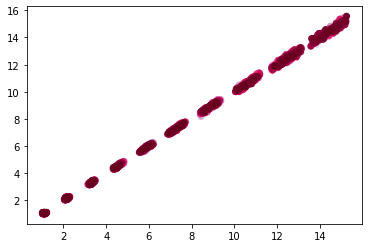

In [67]:
plt.scatter(draw_data['AnnDelayEst'], 
                     y_test, 
                     c=col)